<a href="https://colab.research.google.com/github/KellieChong/E2Metrix-Membrane-Fouling-Model/blob/main/E2metrix_Membrane_Fouling_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we will import the necessary packages.

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math
#import os
#import io
#from six.moves import urllib
from google.colab import files
from scipy.optimize import minimize_scalar, fmin
from mpl_toolkits import mplot3d

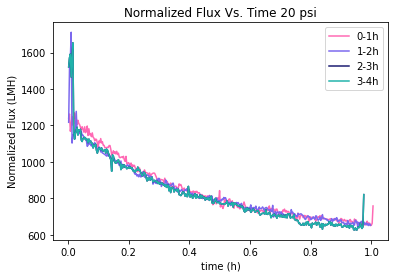

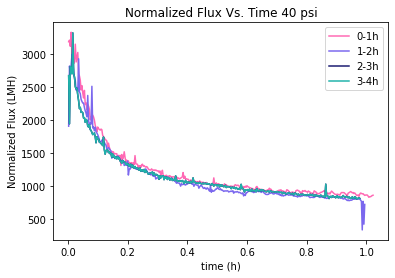

In [6]:
# Now we will add the csv files from my github
# these are from the 200 nm ceramic membrane, ran at 20 psi
url001 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/79d29886800a484d0e519d409848c40f4225547b/200%20nm%20-%2020%20psi/01-20-2021-001.csv"  #First hour of the experiment
url002 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/79d29886800a484d0e519d409848c40f4225547b/200%20nm%20-%2020%20psi/01-20-2021-002.csv" #second hour
url003 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/79d29886800a484d0e519d409848c40f4225547b/200%20nm%20-%2020%20psi/01-20-2021-003.csv"# third hour
url004 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/79d29886800a484d0e519d409848c40f4225547b/200%20nm%20-%2020%20psi/01-20-2021-004.csv" #fourth hour

# Data frames are now to be loaded
df001 = pd.read_csv(url001)
df002 = pd.read_csv(url002)
df003 = pd.read_csv(url003)
df004 = pd.read_csv(url004)


#these are from the 200 nm ceramic membrane, now run at 40 psi 
url101 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/001.csv"
url102 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/002.csv"
url103 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/003.csv"
url104 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/004.csv"

df101 = pd.read_csv(url101)
df102 = pd.read_csv(url102)
df103 = pd.read_csv(url103)
df104 = pd.read_csv(url104)

# Plot our spliced raw data files for visualization
'''plt.plot(df001["time"], df001["J_v"], label = "0-1h")
plt.plot(df002["time"], df002["J_v"], label = "1-2h")
plt.plot(df003["time"], df003["J_v"], label = "2-3h")
plt.plot(df004["time"], df004["J_v"], label = "3-4h")
plt.title = ("Normalized Flux vs. Time")
plt.xlabel = ("time (h)")
plt.ylabel = ("Normalized Flux (LMH)")
plt.legend()
plt.show()'''

#plot using pandas
ax = df001.plot(x="time", y = "J_v", label = "0-1h", xlabel = "time (h)", ylabel = "Normalized Flux (LMH)", title = "Normalized Flux Vs. Time 20 psi", color = "hotpink")
df002.plot(x = "time", y = "J_v", label = "1-2h", xlabel = "time (h)", color = "mediumslateblue", ax=ax)
df003.plot(x = "time", y = "J_v", label = "2-3h", xlabel = "time (h)", color = "midnightblue", ax=ax)
df003.plot(x = "time", y = "J_v", label = "3-4h", xlabel = "time (h)", color = "lightseagreen", ax=ax)

ax2 = df101.plot(x = "time", y = "J_v", label = "0-1h", ylabel = "Normalized Flux (LMH)", title = "Normalized Flux Vs. Time 40 psi", color = "hotpink")
df102.plot(x = "time", y = "J_v", label = "1-2h", xlabel = "time (h)", color = "mediumslateblue", ax=ax2)
df103.plot(x = "time", y = "J_v", label = "2-3h", xlabel = "time (h)", color = "midnightblue", ax=ax2)
df103.plot(x = "time", y = "J_v", label = "3-4h", xlabel = "time (h)", color = "lightseagreen", ax=ax2)

In [18]:
# Let's the user choose the test of interest
# you may need to update the value of test if it does not update automatically
test = widgets.Dropdown(options = [("0-1h", 0), ("1-2h", 1), ("2-3h", 2), ("3-4h", 3)], value = 1, description = "Choose your dataset of interest:", style = {'description_width': 'initial'})
pressure = widgets.Dropdown(options = [("20", 20), ("40", 40)], value = 40, description = "Select your standard operating pressure:", style = {'description_width': 'initial'})
display(test, pressure)

Dropdown(description='Choose your dataset of interest:', index=1, options=(('0-1h', 0), ('1-2h', 1), ('2-3h', …

Dropdown(description='Select your standard operating pressure:', index=1, options=(('20', 20), ('40', 40)), st…

In [25]:
#We need to tell python where to find the correct data frames
if pressure.value == 20:
  df1, df2, df3, df4 = df001, df002, df003, df004
elif pressure.value == 40:
  df1, df2, df3, df4 = df101, df102, df103, df104

# Now we'll create the functions and store them into arrays to later be compared to our raw data to see the mechanism of fouling
#4 possibilities exist: 1:Complete Pore Blocking, 2: Intermediate Blocking, 3: Pore constriction, and 4: Cake filtration
database = [[df1["J_v"][0], df2["J_v"][0], df3["J_v"][0], df4["J_v"][0]], #the Jo values
            [df1["J_v"], df2["J_v"], df3["J_v"], df004["J_v"]], # J_v values
            [df1["time"], df2["time"], df3["time"], df4["time"]]] # time intervals
mechanism = {
    "[0]": "Complete Pore Blocking",
    "[1]": "Intermediate Blocking",
    "[2]": "Pore Constriction",
    "[3]": "Cake filtration"
}

# These are all column vectors
Y = database[1][test.value].to_numpy()/database[0][test.value]
t = database[2][test.value]
K_block = np.linspace(0, 1.0, len(t))

x, y = np.meshgrid(t, K_block)
z = np.square(Y - np.exp(-x*y))
#def K_block (K_block, t):
#    sol1 = np.exp((np.transpose(K_block)) * -t)
#    return sol1

#print(Y)
#t_reshaped = np.reshape(-t, (1, len(t)))
#K_b_reshaped = np.reshape(K_block, (len(t), 1))
#y_pred = np.reshape(K_block, (len(t), 1)) * np.reshape(-t, (1, len(t)))
Y_mat = np.tile(np.array(np.reshape(Y, (1, len(t)))), (len(t), 1))
#print(Y_mat.shape)
y_pred = np.zeros((len(t), len(t)))

i=0
j=0

for i in range(len(t)):
  for j in range(len(t)):
    y_pred[i][j] = np.exp(K_block[i] * -t[j])
    if j == len(t):
      break
    else:
      j += 1
  i += 1
  if i == len(t):
    break

#RSS = np.square((Y_mat - y_pred))

#print(RSS)
#print(y_pred)

#def RSS(K_block, t, Y):
    #y_pred = K_block(K_block, t)
 #   residual_sum = sum((Y - y_pred) ** 2)
 #   return residual_sum

#print(np.reshape(K_block, (len(t),1)))
#fig1 = plt.figure(figsize =(6,6))
#ax = fig1.add_subplot(projection='3d')
#ax.plot_surface(x, y, z)
#plt.xlabel("time (h)")
#plt.ylabel("K_block")
#ax.set_zlabel("RSS")

#plt.imshow(RSS)
#plt.colorbar()
#plt.show()
#res = minimize_scalar(RSS, bounds=(-100, 100), method= 'bounded')
#res.x 



**Data Visualization:**

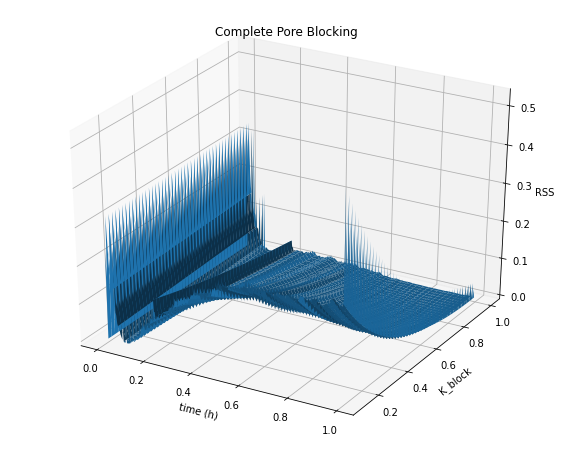

Complete pore blocking min RSS:  1.5034894477827237e-13
Intermediate Blocking min RSS:  0.06302403138730328
Pore Constriction min RSS:  0.003972028532307789
Cake Filtration min RSS:  0.003972028532307789


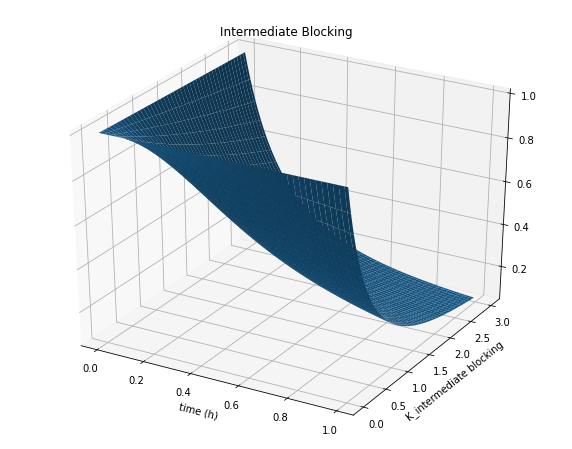

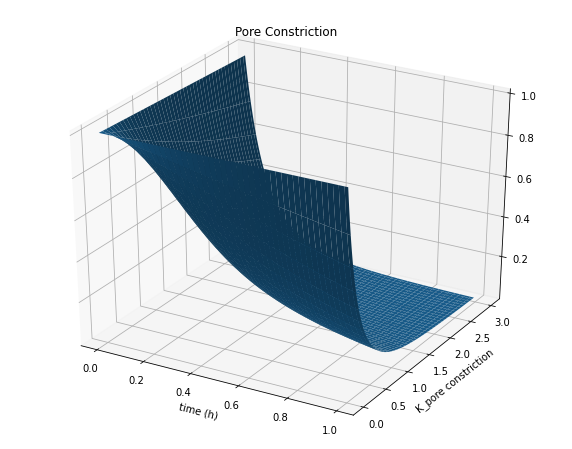

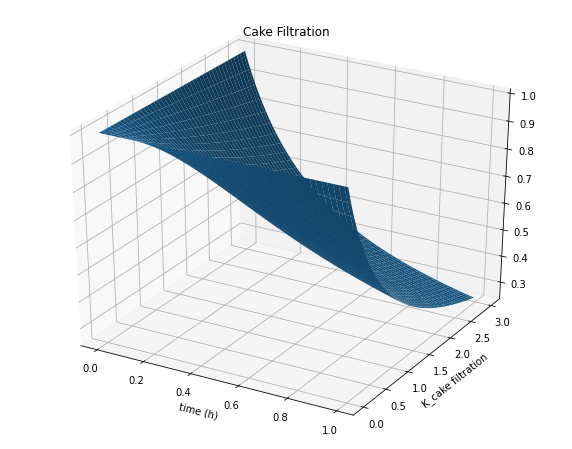

In [26]:
Y = database[1][test.value].to_numpy()/database[0][test.value]
t = database[2][test.value]
K_block = np.linspace(0.1, 1.0, len(t))
K_inter = np.linspace(0, 3, len(t))

# returns a 2D coordinate matrix from coordinate vectors of 1D
x, y = np.meshgrid(t, K_block)
x2, y2 = np.meshgrid(t, K_inter)

# define all the functions for RSS of the mechanisms
z1 = np.square(Y - np.exp(-x*y))
z2 = np.square(np.power((1 + x2 * y2),-1))
z3 = np.square(np.power((1 + x2 * y2),-2))
z4 = np.square(np.power((1 + x2 * y2),-0.5))

# finds minimum RSS for a single time point if you wish, add this parameter to your plot if you want to see it
zmin = np.min(z1)
mask = np.array(1) == zmin
color = np.where(mask,'red', 'blue')

# complete pore blocking
fig1 = plt.figure(figsize =(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(x, y, z1)
plt.xlabel("time (h)")
plt.ylabel("K_block")
ax1.set_zlabel("RSS")
ax1.set_title("Complete Pore Blocking")
plt.show()
print("Complete pore blocking min RSS: ", np.min(z1))

#Intermediate Blocking
fig2 = plt.figure(figsize =(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(x2, y2, z2)
ax2.set_title("Intermediate Blocking")
ax2.set_xlabel("time (h)")
ax2.set_ylabel("K_intermediate blocking")
print("Intermediate Blocking min RSS: ", np.min(z2))

#Pore Constriction
fig3 = plt.figure(figsize =(10, 8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(x2, y2, z3)
ax3.set_title("Pore Constriction")
ax3.set_xlabel("time (h)")
ax3.set_ylabel("K_pore constriction")
print("Pore Constriction min RSS: ", np.min(z3))

#Cake Filtration
fig4 = plt.figure(figsize =(10, 8))
ax4 = fig4.add_subplot(111, projection='3d')
ax4.plot_surface(x2, y2, z4)
ax4.set_title("Cake Filtration")
ax4.set_xlabel("time (h)")
ax4.set_ylabel("K_cake filtration")
print("Cake Filtration min RSS: ", np.min(z3))

#plot all now
plt.show()

**Integrate the graphs over the entire time domain, and K_i -> K_i+1 now:**

In [27]:
#Now that we can visually see if we are on the right track or not, we want to take slice integrals of all t values for a certain K_i -> K_i+1

def Z1(x, y, Y):
  return np.square(Y - np.exp(-x*y))

def Z2(x, y, Y):
  return np.square(Y - np.power((1+x*y), -1))


def Z3(x, y, Y):
  return np.square(Y - np.power((1+x*y), -2))


def Z4(x, y, Y):
  return np.square(Y - np.power((1+x*y), -0.5))

i = 0
j = 0
RSS = np.zeros((len(t), 4))
#the j index is for the K vector
#the i index is to iterate through the entire time domain

for j in range(len(t)):
  #reinitialize the value of the columns
  col1 = 0
  col2 = 0
  col3 = 0
  col4 = 0 
  for i in range(len(t)):
    col1 += Z1(t[i], K_block[j], Y[i])
    col2 = Z2(t[i], K_inter[j], Y[i])
    col3 += Z3(t[i], K_inter[j], Y[i])
    col4 += Z4(t[i], K_inter[j], Y[i])
  
  RSS[j] = [col1, col2, col3, col4]
  j += 1
  
#print(RSS)
print("Some Model Metrics: ")
print("maximum RSS: " , np.amax(RSS))
print("maximum RSS index: ", np.where(RSS == np.amax(RSS)))
print("minimum RSS: ", np.amin(RSS))
print("minimum RSS index: ", np.where(RSS == np.amin(RSS)))


Some Model Metrics: 
maximum RSS:  78.25122003980844
maximum RSS index:  (array([0, 0]), array([2, 3]))
minimum RSS:  8.22280563654127e-09
minimum RSS index:  (array([196]), array([1]))


Compute the Optimal K value and proposed mechanism of fouling

In [28]:
index = (np.where(RSS == np.amin(RSS)))
if index[1] == 0:
  K = K_block
else:
  K = K_inter

method = mechanism[str(index[1])]
K_optimal = float(K[(index[0])])

print("The proposed mechanism of fouling is: ", method)
print("The optimal K value is: ", K_optimal) #K_optimal


The proposed mechanism of fouling is:  Intermediate Blocking
The optimal K value is:  1.6470588235294117


In [ ]:
#@title
#print(K_block[1])
#print(t[1])
#print(Y[1])

def Z1(x, y, Y):
  return np.square(Y - np.exp(-x*y))

def Z2(x, y, Y):
  return np.square(Y - np.power((1+x*y), -1))

def Z3(x, y, Y):
  return np.square(Y-np.power((1+x*y), -2))

def Z4(x, y, Y):
  return np.square(Y-np.power((1+x*y), -0.5))

Z1(t[1], K_block[1], Y[1])

i=0
j = 0
sum1 = 0
sum2 = 0
ans = Z2(t[i], K_inter[j], Y[i])
print(len(t))

for j in range(len(t)):
  sum1 = 0
  sum2 = 0
  sum3 = 0
  sum4 = 0 
  for i in range(len(t)):
    sum1 += Z1(t[i], K_block[j], Y[i])
    sum2 = Z2(t[i], K_inter[j], Y[i])
    sum3 += Z3(t[i], K_inter[j], Y[i])
    sum4 += Z4(t[i], K_inter[j], Y[i])
  
  RSS[j] = [sum1, sum2, sum3, sum4]
  j += 1
  
print(RSS[2])

359
[29.05537151  0.2002592  37.38097506 40.65555191]


**Plotting Our Model versus the Raw Data now**

The total RSS of this model is:  4.349139459026876


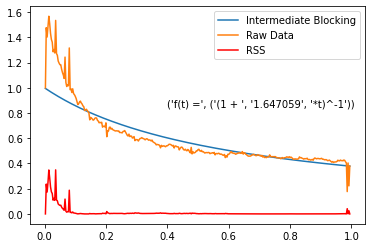

In [30]:
if index[1] == 0:
  y_pred = np.exp(-K_optimal * t)
  eqn = "exp(-","%.6f" % K_optimal,"*t)"
elif index[1] == 1:
  y_pred = np.power((1+(K_optimal*t)), -1)
  eqn = '(1 + ','%.6f' % K_optimal,"*t)^-1"
elif index[1] == 2:
  y_pred = np.power((1+(K_optimal*t)), -2)
  eqn = "(1 + ","%.6f" % K_optimal,"*t)^-2"
else:
  np.power((1+(K_optimal*t)), -0.5)
  eqn = "(1 + ","%.6f" % K_optimal,"*t)^-0.5"

RSS_2D_plot = np.square((Y-y_pred))
print("The total RSS of this model is: ", np.sum(RSS_2D_plot))

plt.ylabel = "Normalized Flux Ratio (Jv/Jo)"
plt.xlabel = "time(h)"
plt.plot(t, y_pred, label = method)
plt.plot(t, Y, label = 'Raw Data')
plt.plot(t, RSS_2D_plot, label = 'RSS', color = 'r')
plt.title = "Fouling Model vs. Raw Data"
plt.legend(loc = "best")
plt.text(0.4, .85, ('f(t) =', eqn))
plt.show()
